**Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
import xgboost as xgb


**Generate Dummy Data**

In [ ]:
np.random.seed(42)
n_samples = 10000

data = pd.DataFrame({
    'loan_id': range(1, n_samples + 1),
    'income': np.random.normal(50000, 15000, n_samples),
    'age': np.random.randint(21, 70, n_samples),
    'loan_amount': np.random.normal(15000, 5000, n_samples),
    'loan_term': np.random.choice([12, 24, 36, 48, 60], n_samples),
    'credit_score': np.random.randint(300, 850, n_samples),
    'num_of_dependents': np.random.randint(0, 5, n_samples),
    'employment_years': np.random.randint(0, 40, n_samples),
    'home_ownership': np.random.choice(['rent', 'own', 'mortgage', 'other'], n_samples),
})

# Default generation
data['default'] = np.where(
    (data['credit_score'] < 600) & (data['loan_amount'] > 20000), 1, 0
)
data['default'] = np.where(np.random.rand(n_samples) < 0.05, 1, data['default'])
data['default'] = data['default'].astype(int)

**Missing Value Treatment**

In [ ]:
for col in ['income','age','loan_amount','credit_score','employment_years']:
    data.loc[data.sample(frac=0.02, random_state=42).index, col] = np.nan

for col in data.select_dtypes(include=[np.number]).columns:
    data[col] = data[col].fillna(data[col].median())

for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].fillna(data[col].mode()[0])

**Feature Engineering**

In [ ]:
data['income_to_loan_ratio'] = data['income'] / data['loan_amount']
data['age_group'] = pd.cut(data['age'], bins=[20, 30, 40, 50, 60, 70], labels=False)
data['loan_to_term_ratio'] = data['loan_amount'] / data['loan_term']
data['employment_to_age_ratio'] = data['employment_years'] / (data['age']+1e-5)

**WOE & IV Functions**

In [ ]:
def calc_woe_iv(df, feature, target, bins=10):
    temp = df.copy()

    if temp[feature].dtype == 'object' or len(temp[feature].unique()) < 10:
        grouped = temp.groupby(feature)[target].agg(['count','sum'])
    else:
        temp['bin'] = pd.qcut(temp[feature], q=bins, duplicates='drop')
        grouped = temp.groupby('bin')[target].agg(['count','sum'])

    grouped.columns = ['total','bad']
    grouped['good'] = grouped['total'] - grouped['bad']

    dist_good = grouped['good'] / grouped['good'].sum()
    dist_bad = grouped['bad'] / grouped['bad'].sum()

    grouped['woe'] = np.log((dist_good + 1e-5) / (dist_bad + 1e-5))
    grouped['iv'] = (dist_good - dist_bad) * grouped['woe']

    mapping = grouped['woe'].to_dict()

    return mapping, grouped['iv'].sum()

def woe_transform(df, features, target):
    woe_maps = {}
    iv_summary = {}
    df_woe = df.copy()

    for f in features:
        mapping, iv = calc_woe_iv(df, f, target)
        iv_summary[f] = iv

        if df[f].dtype == 'object' or len(df[f].unique()) < 10:
            df_woe[f + "_woe"] = df[f].map(mapping)
        else:
            df_woe[f + "_bin"] = pd.qcut(df[f], q=10, duplicates='drop')
            df_woe[f + "_woe"] = df_woe[f + "_bin"].map(mapping)
            df_woe.drop(columns=[f + "_bin"], inplace=True)

    return df_woe, iv_summary

**Apply WOE Transformation**

In [ ]:
features = ['income','age','loan_amount','loan_term','credit_score',
            'num_of_dependents','employment_years','home_ownership',
            'income_to_loan_ratio','age_group','loan_to_term_ratio',
            'employment_to_age_ratio']

data_woe, iv_summary = woe_transform(data, features, 'default')

iv_df = pd.DataFrame.from_dict(iv_summary, orient='index', columns=['IV']).sort_values(by='IV', ascending=False)
print("IV Scores:\n", iv_df)

IV Scores:
                                IV
loan_amount              1.544511
income_to_loan_ratio     0.511479
credit_score             0.465322
loan_to_term_ratio       0.389621
employment_to_age_ratio  0.011050
income                   0.011036
age                      0.007142
employment_years         0.006345
age_group                0.006272
loan_term                0.003949
home_ownership           0.002921
num_of_dependents        0.000353


/tmp/ipython-input-3793179947.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = temp.groupby('bin')[target].agg(['count','sum'])
/tmp/ipython-input-3793179947.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = temp.groupby('bin')[target].agg(['count','sum'])
/tmp/ipython-input-3793179947.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = temp.groupby('bin')[target].agg(['count','sum'])
/

**PD Model with WOE (Scorecard Style)**

In [ ]:
woe_features = [f + "_woe" for f in features]
X = data_woe[woe_features]
y = data_woe['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logit = LogisticRegression(max_iter=1000)
logit.fit(X_train, y_train)

data['PD_logit_woe'] = logit.predict_proba(X)[:,1]
print("Scorecard Logistic PD AUC:", roc_auc_score(y, data['PD_logit_woe']))

Scorecard Logistic PD AUC: 0.8207885262536232


**PD with XGBoost (benchmark)**

In [ ]:
X_enc = pd.get_dummies(data[features], drop_first=True)
X_train_enc, X_test_enc, y_train, y_test = train_test_split(X_enc, y, test_size=0.3, random_state=42)

pd_model_xgb = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
pd_model_xgb.fit(X_train_enc, y_train)

data['PD_xgb'] = pd_model_xgb.predict_proba(X_enc)[:,1]
print("XGBoost PD AUC:", roc_auc_score(y, data['PD_xgb']))

XGBoost PD AUC: 0.9336580997828506


**LGD + ECL**

In [ ]:
data['LGD'] = np.where(data['default']==1, np.random.uniform(0.2, 0.9, n_samples), 0)
lgd_data = data[data['default']==1]

X_lgd = X_enc.loc[lgd_data.index]
y_lgd = lgd_data['LGD']

lgd_model_xgb = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
lgd_model_xgb.fit(X_lgd, y_lgd)

data['LGD_xgb'] = lgd_model_xgb.predict(X_enc).clip(0,1)
data['EAD'] = data['loan_amount']
data['ECL'] = data['PD_xgb'] * data['LGD_xgb'] * data['EAD']

**Risk Buckets & Stress Testing**

In [ ]:
data['risk_bucket'] = pd.qcut(data['PD_xgb'], q=3, labels=['Low','Medium','High'])

stress_PD = (data['PD_xgb'] * 1.2).clip(0,1)
stress_LGD = (data['LGD_xgb'] * 1.15).clip(0,1)
data['ECL_stress'] = stress_PD * stress_LGD * data['EAD']

print("Normal Portfolio ECL:", data['ECL'].sum())
print("Stress Portfolio ECL:", data['ECL_stress'].sum())

Normal Portfolio ECL: 14073702.132706404
Stress Portfolio ECL: 17082003.71736807


**Visualization**

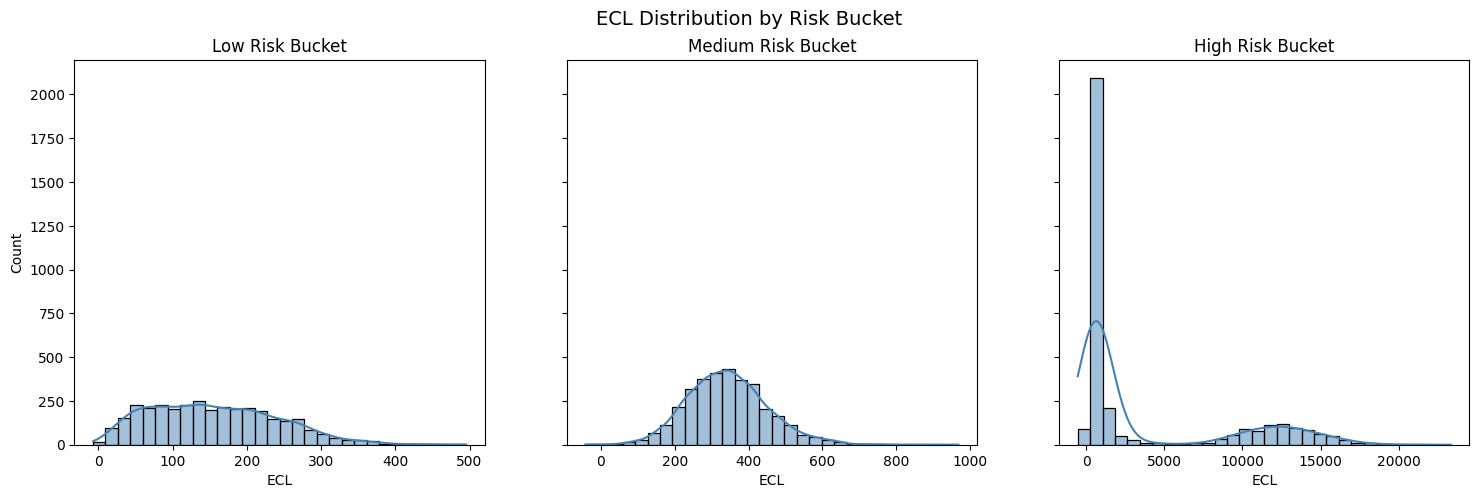

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
for i, bucket in enumerate(['Low','Medium','High']):
    subset = data[data['risk_bucket'] == bucket]
    sns.histplot(subset['ECL'], bins=30, kde=True, ax=axes[i], color='steelblue')
    axes[i].set_title(f"{bucket} Risk Bucket")
plt.suptitle("ECL Distribution by Risk Bucket", fontsize=14)
plt.show()


**Scorecard Scaling from WOE Logistic**

In [ ]:
# Logistic regression parameters
intercept = logit.intercept_[0]
coefs = logit.coef_[0]

# Define scorecard parameters (common in banking)
# e.g., Score = Offset + Factor * (Log(odds))
# We'll map odds from PD into 300–900 scale

PDO = 50              # Points to Double the Odds
BaseScore = 600       # Base score
BaseOdds = 20         # Odds at BaseScore (Good:Bad ratio)

# Calculate scaling factor
factor = PDO / np.log(2)
offset = BaseScore - factor * np.log(BaseOdds)

# Convert PD to score
data['odds'] = (1 - data['PD_logit_woe']) / data['PD_logit_woe']
data['credit_score'] = offset + factor * np.log(data['odds'])

# Clip scores to 300–900
data['credit_score'] = data['credit_score'].clip(300, 900)

print(data[['PD_logit_woe','odds','credit_score']].head())


   PD_logit_woe       odds  credit_score
0      0.011418  86.582104    705.703443
1      0.068235  13.655293    572.473013
2      0.351658   1.843672    428.032686
3      0.028316  34.316043    638.944161
4      0.131359   6.612706    520.165629


**Visualize Credit Scores**

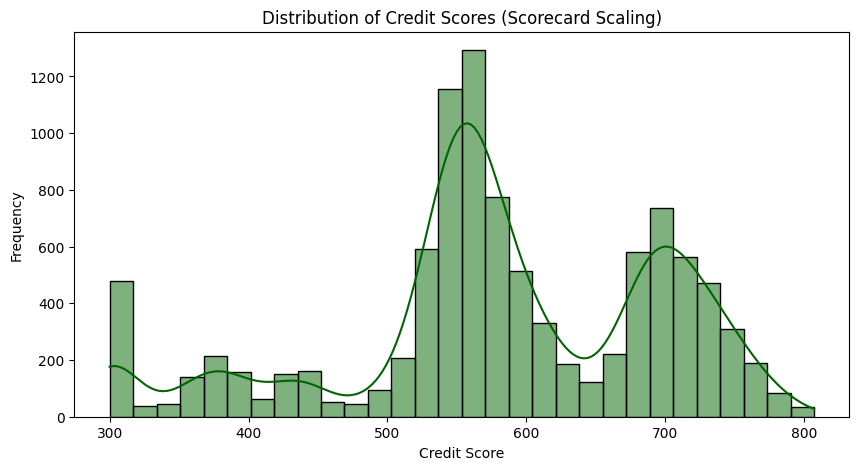

credit_grade
High Risk         4438
Medium Risk       2055
Low Risk          1886
Very High Risk    1616
Very Low Risk        5
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(data['credit_score'], bins=30, kde=True, color='darkgreen')
plt.title("Distribution of Credit Scores (Scorecard Scaling)")
plt.xlabel("Credit Score")
plt.ylabel("Frequency")
plt.show()

# Segment borrowers into grades
bins = [300,500,600,700,800,900]
labels = ['Very High Risk','High Risk','Medium Risk','Low Risk','Very Low Risk']
data['credit_grade'] = pd.cut(data['credit_score'], bins=bins, labels=labels, right=False)

print(data['credit_grade'].value_counts())